In [2]:
import numba
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit
import scipy
from scipy.spatial.transform import Rotation as Rot
from itertools import permutations

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [4]:


T=1
R=1
a = 10*R
epsilons = np.linspace(0.1,5,50)*R

steps = 1000
nsteps = 1000
dt = T/steps




etas = np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])

In [5]:
@njit
def mul(a,b):
    ans = np.zeros((5,5,3,3))
    for i in range(5):
        for j in range(5):
            ans[i,j] = a @ b[i,j]
    return ans

def visualize(r,angles=(0,0)):
    ax = plt.figure().add_subplot(projection='3d')
    colors = ('r', 'g', 'b', 'k','y')
    ax.scatter(xs = r[:,0],ys = r[:,1] , zs=r[:,2],c=colors,s=100)
    
    for j in range(0,5):
        ax.plot(xs = [r[j,0] , r[0,0]] , ys = [r[j,1] , r[0,1]] , zs = [r[j,2] , r[0,2]],c="b")
    
    ax.view_init(angles[0],angles[1])
    return ax


def getAngle(a,b):
    return (180/np.pi)*np.arccos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))



@njit
def getDistanceMatrix(A):   # dij = rj - ri
    tiledPoses = tile(A)
    distances = tiledPoses - tiledPoses.transpose((1,0,2))
    return distances



@njit
def tile(x):
    tiled = np.zeros((5,5,3))
    for i in range(5):
        tiled[i,:,:] = x
        
    return tiled


def getR0(ls):
    a1,a2,a3,a4 = ls
    
    R0 = [[0, 0, 0],
    [0, 0, a1],
    [a2*np.sqrt(8)/3, 0 , -a2/3],
    [-a3*np.sqrt(8)/6, a3*np.sqrt(24)/6 , -a3/3],
    [-a4*np.sqrt(8)/6, -a4*np.sqrt(24)/6, -a4/3]]
    
    return np.array(R0)




@njit
def tile2(x):
    tiled = np.zeros((5,5,3,3))
    for i in range(3):
        for j in range(3):
            tiled[:,:,i,j] = x
        
    return tiled


@njit
def getO(d,R):
    d2 = d**2    
    drNorm = np.sum(d2,axis=2)**0.5
            
    
    I5_5_3_3 = np.zeros((5,5,3,3))

    for i in range(5):
        for j in range(5):
            I5_5_3_3[i,j,:,:] = np.eye(3)


    c1 = d.reshape(5,5,3,1)
    c2 = c1.transpose(0,1,3,2)    
    B = np.multiply(c1,c2)    
    c3 = tile2(drNorm)

    O = R*(I5_5_3_3 + B/(c3**2))*0.75/c3 #*R/norm(l)

    for i in range(5):  #for i=j
        O[i,i,:,:] = np.eye(3)
        
    return mul(etas,O)

@njit
def getRR(r):
    rr0 = np.array([
    
    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]])
    
    
    rr1 = np.array([[0, -r[0,2] , r[0,1],  0, -r[1,2] , r[1,1],    0, -r[2,2] , r[2,1], 0, -r[3,2] , r[3,1]   ,0, -r[4,2] , r[4,1]],
    [r[0,2], 0 , -r[0,0],   r[1,2], 0 , -r[1,0],  r[2,2], 0 , -r[2,0],  r[3,2], 0 , -r[3,0],  r[4,2], 0 , -r[4,0]],
    [-r[0,1], r[0,0], 0 , -r[1,1], r[1,0], 0 , -r[2,1], r[2,0], 0 ,   -r[3,1], r[3,0], 0 ,  -r[4,1], r[4,0], 0 ]])
    
    


    
    return np.concatenate((rr0,rr1),axis=0)


@njit
def getOO(d):
    ##Check
    k2_3 = np.dot(d[1,0],d[1,0])*np.dot(d[2,0],d[2,0])/np.dot(d[1,0],d[2,0])
    k2_4 = np.dot(d[1,0],d[1,0])*np.dot(d[3,0],d[3,0])/np.dot(d[1,0],d[3,0])
    k2_5 = np.dot(d[1,0],d[1,0])*np.dot(d[4,0],d[4,0])/np.dot(d[1,0],d[4,0])
    k3_4 = np.dot(d[2,0],d[2,0])*np.dot(d[3,0],d[3,0])/np.dot(d[2,0],d[3,0])
    k3_5 = np.dot(d[2,0],d[2,0])*np.dot(d[4,0],d[4,0])/np.dot(d[2,0],d[4,0])

    p2_3 = np.dot(d[2,0],d[2,0])*d[0,1] - k2_3*d[0,2] 
    p2_4 = np.dot(d[3,0],d[3,0])*d[0,1] - k2_4*d[0,3] 
    p2_5 = np.dot(d[4,0],d[4,0])*d[0,1] - k2_5*d[0,4] 
    p3_4 = np.dot(d[3,0],d[3,0])*d[0,2] - k3_4*d[0,3] 
    p3_5 = np.dot(d[4,0],d[4,0])*d[0,2] - k3_5*d[0,4] 


    q2_3 = np.dot(d[1,0],d[1,0])*d[0,2] - k2_3*d[0,1] 
    q2_4 = np.dot(d[1,0],d[1,0])*d[0,3] - k2_4*d[0,1] 
    q2_5 = np.dot(d[1,0],d[1,0])*d[0,4] - k2_5*d[0,1] 
    q3_4 = np.dot(d[2,0],d[2,0])*d[0,3] - k3_4*d[0,2] 
    q3_5 = np.dot(d[2,0],d[2,0])*d[0,4] - k3_5*d[0,2] 
    
    
    OO = np.array([
        [d[1,0,0], d[1,0,1], d[1,0,2], -d[1,0,0], -d[1,0,1], -d[1,0,2], 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [d[2,0,0], d[2,0,1], d[2,0,2], 0, 0, 0, -d[2,0,0], -d[2,0,1], -d[2,0,2], 0, 0, 0, 0, 0, 0,   ],   
    [d[3,0,0], d[3,0,1], d[3,0,2], 0, 0, 0, 0, 0, 0, -d[3,0,0], -d[3,0,1], -d[3,0,2], 0, 0, 0],
    [d[4,0,0], d[4,0,1], d[4,0,2], 0, 0, 0, 0, 0, 0, 0, 0, 0, -d[4,0,0], -d[4,0,1], -d[4,0,2]],
    
    [-p2_3[0] -q2_3[0], -p2_3[1] -q2_3[1], -p2_3[2] -q2_3[2],                p2_3[0], p2_3[1], p2_3[2], q2_3[0], q2_3[1], q2_3[2], 0, 0, 0, 0, 0, 0], #2_3,
    [-p2_4[0] -q2_4[0], -p2_4[1] -q2_4[1], -p2_4[2] -q2_4[2],                p2_4[0], p2_4[1], p2_4[2], 0, 0, 0, q2_4[0], q2_4[1], q2_4[2], 0, 0, 0],  #2_4,
    [-p2_5[0] -q2_5[0], -p2_5[1] -q2_5[1], -p2_5[2] -q2_5[2],                p2_5[0], p2_5[1], p2_5[2], 0, 0, 0, 0, 0, 0, q2_5[0], q2_5[1], q2_5[2]], #2_5
    [-p3_4[0] -q3_4[0], -p3_4[1] -q3_4[1], -p3_4[2] -q3_4[2],                0, 0, 0, p3_4[0], p3_4[1], p3_4[2], q3_4[0], q3_4[1], q3_4[2], 0, 0, 0],  #3_4
    [-p3_5[0] -q3_5[0], -p3_5[1] -q3_5[1], -p3_5[2] -q3_5[2],                0, 0, 0, p3_5[0], p3_5[1], p3_5[2], 0, 0, 0, q3_5[0], q3_5[1], q3_5[2]] #3_5
    
    ])
    
    return OO




@njit
def getC(l,u):
    lu = np.zeros(4)
    for i in range(4):
        lu[i]= (l[i]*u[i])
        
    
    return np.array([*list(lu), 0,0,0,0,0,0,0,0, 0,0,0])  

#  u -> u/steps maybe



def getV(r,l,u,R):
    d = getDistanceMatrix(r)

    O = getO(d,R)
    newO = np.zeros((15,15))
    for i in range(5):
        for j in range(5):
            newO[3*i:3*i+3,3*j:3*j+3] = O[i,j]
        
    rr= getRR(r)
    mm = np.linalg.inv(newO)


    NN = np.matmul(rr,mm)
    OO = getOO(d)
    AA = np.concatenate((OO,NN),axis=0)
    
    
    

    BB = getC(l,u)
    
    return np.linalg.solve(AA,BB)
        
     
        
def step(r,L,R):
    for t in range(1000):
        try:
            U = L[:,t+1]-L[:,t]
        except IndexError:
            U = L[:,t]-L[:,t-1]
            
        v = getV(r,L[:,t],U,R).reshape((5,3))
        
        r += v  ##########

        # print(t)
        # print(totalDelta)
        # print((totalRotation @ r.T).T  + totalDelta)
        

        
        
    return r  



def act(L,R):
    r = getR0(L[:,0])
    r_final = step(r.copy(),L,R)
    delta = list(r_final - r)[0]
    
    return r_final,delta,np.matmul(getE(r_final), np.linalg.inv(getE(r)))


def getE(r):
    e1 = ((r[1]-r[0])/np.linalg.norm((r[1]-r[0]))).reshape((3,1))
    e2 = ((r[2]-r[0])/np.linalg.norm((r[2]-r[0]))).reshape((3,1))
    e3 = ((r[3]-r[0])/np.linalg.norm((r[3]-r[0]))).reshape((3,1))
    
    return np.concatenate((e1,e2,e3),axis=1)





In [23]:
Rs = np.linspace(1,3,20)

In [7]:
mirror = np.array([[1., 0., 0.],[0., -1., 0.],[0., 0., -1.]]) 
(mirror @ np.ones((5,3)).T).T

array([[ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.]])

In [8]:
np.array([1,2,3])  + np.ones((5,3))

array([[2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.]])

In [9]:
a = 10*R
epsilon = 0.3*a
closing  = a - np.arange(steps+1)*epsilon/steps
opening = a - epsilon + np.arange(steps+1)*epsilon/steps
opened = a *np.ones(steps+1)
closed = (a-epsilon)*np.ones(steps+1)

totalRotation = np.eye(3)
totalDelta = 0


    
act(np.array([closing,opened,opened,opened]),R)

(array([[ 2.62425877e-18,  1.26151564e-19,  5.41629061e-01],
        [ 5.39007544e-18, -5.28603877e-19,  7.54162906e+00],
        [ 9.42809042e+00,  2.09370016e-18, -2.79170427e+00],
        [-4.71404521e+00,  8.16496581e+00, -2.79170427e+00],
        [-4.71404521e+00, -8.16496581e+00, -2.79170427e+00]]),
 array([2.62425877e-18, 1.26151564e-19, 5.41629061e-01]),
 array([[ 1.00000000e+00, -1.95126984e-17,  3.95116667e-19],
        [ 1.75619900e-19,  1.00000000e+00, -9.35364915e-20],
        [-5.55111512e-17, -1.44291227e-16,  1.00000000e+00]]))

In [10]:
data3 = np.zeros((20,6))
thetas3 = np.zeros(50)
for i in range(20):
    R = Rs[i]

    a = 10*R
    epsilon = 0.3*a
    closing  = a - np.arange(steps+1)*epsilon/steps
    opening = a - epsilon + np.arange(steps+1)*epsilon/steps
    opened = a *np.ones(steps+1)
    closed = (a-epsilon)*np.ones(steps+1)

    totalRotation = np.eye(3)
    totalDelta = 0


    
    rf1,delta,Rotation=  act(np.array([closing,opened,opened,opened]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf2,delta,Rotation=  act(np.array([closed,closing,opened,opened]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf3,delta,Rotation=  act(np.array([closed,closed,closing,opened]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf4,delta,Rotation=  act(np.array([closed,closed,closed,closing]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf5,delta,Rotation=  act(np.array([opening,closed,closed,closed]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf6,delta,Rotation=  act(np.array([opened,opening,closed,closed]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf7,delta,Rotation=  act(np.array([opened,opened,opening,closed]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf8,delta,Rotation=  act(np.array([opened,opened,opened,opening]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)
    
    
    data3[i,0:3] = totalDelta
    data3[i,3:6] = Rot.from_matrix(totalRotation).as_euler("xyz",degrees=True)
    thetas3[i] = np.arccos((1 - np.trace(totalRotation))/2)

1.0000000000000295
0.9999999999998961
0.9999999999999782
6.627012232785382e-14
3.078992606151212e-14
-1.2053727415826272e-13


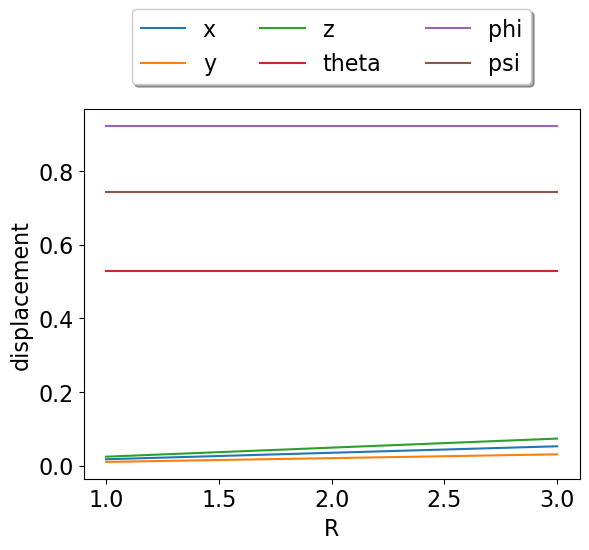

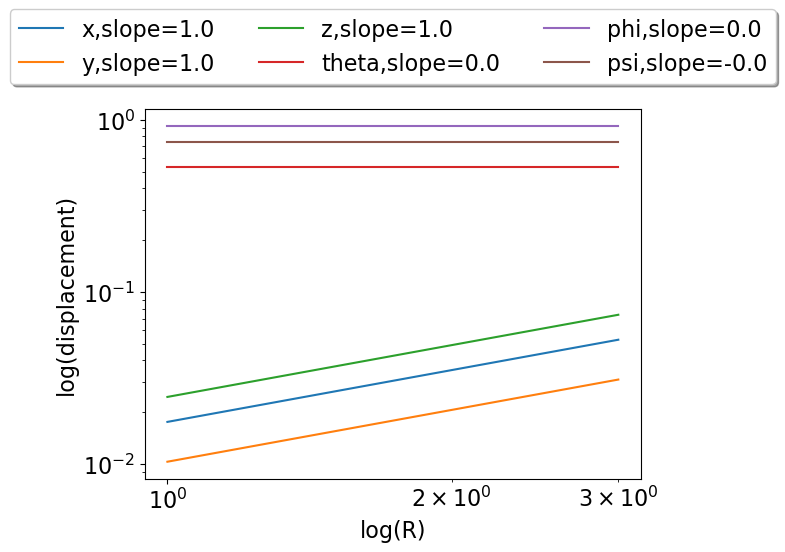

In [11]:
slopes3 = []  
for i in range(6):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(Rs[:]),np.log(np.abs(data3[:,i])))
    slopes3.append(slope)
    print(slope)

plt.Figure(figsize=(10,10))
#plt.title("change in position and orientation vs R for a=10R and eps=3")
plt.xlabel("R")
plt.ylabel("displacement")
for i in range(6):
    plt.plot(Rs,np.abs(data3[:,i]))
plt.legend(["x","y","z","theta","phi","psi"],loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=3, fancybox=True, shadow=True)
plt.savefig("displacement3.png", bbox_inches="tight")
plt.show()


plt.Figure(figsize=(10,10))
#plt.title("log of change in position and orientation vs R for a=10R and eps=3")
plt.xlabel("log(R)")
plt.ylabel("log(displacement)")
for i in range(6):
    plt.loglog(Rs,np.abs(data3[:,i]))
plt.legend([f"x,slope={np.round(slopes3[0],2)}",f"y,slope={np.round(slopes3[1],2)}",f"z,slope={np.round(slopes3[2],2)}",f"theta,slope={np.round(slopes3[3],2)}",f"phi,slope={np.round(slopes3[4],2)}",f"psi,slope={np.round(slopes3[5],2)}"],loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=3, fancybox=True, shadow=True)
plt.savefig("log_displacement3.png", bbox_inches="tight")
plt.show()


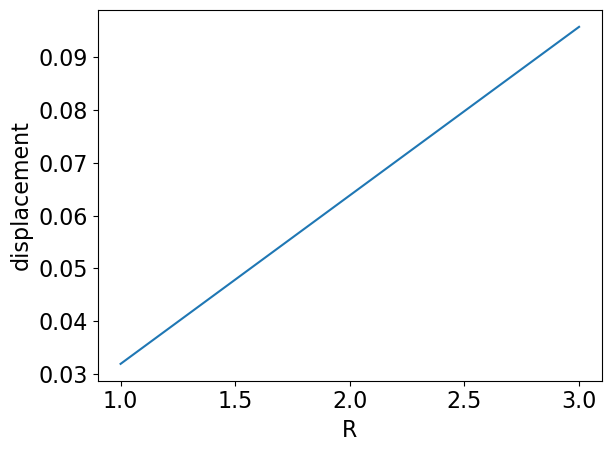

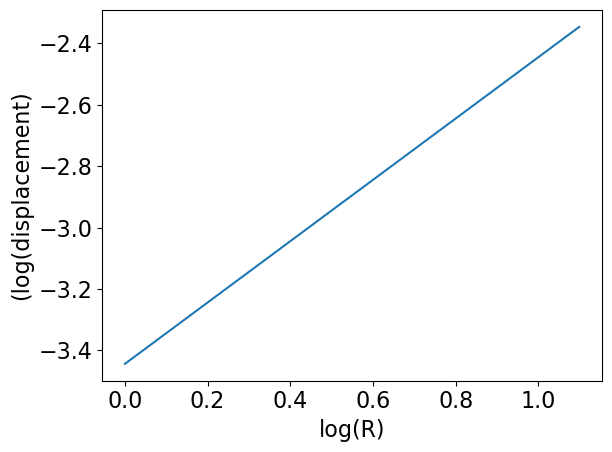

In [12]:


plt.Figure(figsize=(10,10))
plt.subplots(tight_layout=True)
plt.plot(Rs,np.linalg.norm(data3[:,0:3],axis=1))



# slope  = scipy.stats.linregress(np.log(epsilons),np.log(np.linalg.norm(data[:,0:3],axis=1)))[0]

plt.xlabel("R")
plt.ylabel("displacement")
# plt.title(f"displacement vs R")





plt.savefig("displacement3.png", bbox_inches="tight")
plt.show()



plt.Figure(figsize=(10,10))
plt.subplots(tight_layout=True)
plt.plot(np.log(Rs),np.log(np.linalg.norm(data3[:,0:3],axis=1)))



slope  = scipy.stats.linregress(np.log(Rs),np.log(np.linalg.norm(data3[:,0:3],axis=1)))[0]

plt.xlabel("log(R)")
plt.ylabel("(log(displacement)")
# plt.title(f"log(displacement) vs log(R), slope = {np.round(slope,3)}")





plt.savefig("log_displacement3.png", bbox_inches="tight")
plt.show()





# plt.Figure(figsize=(10,10))

# plt.plot(As,np.linalg.norm(data2[:,0:3],axis=1))

# plt.savefig("displacement2.png")

In [13]:
from numpy import log

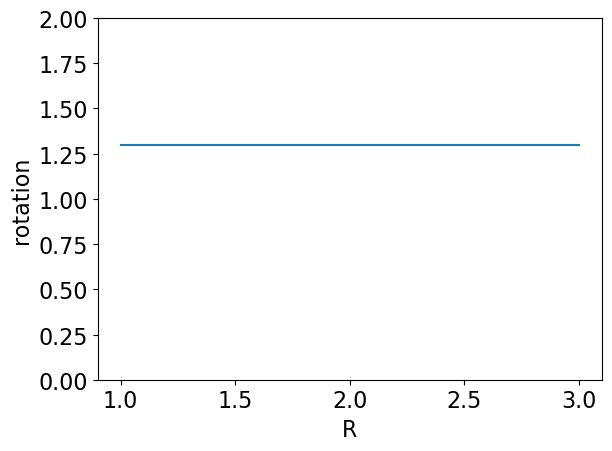

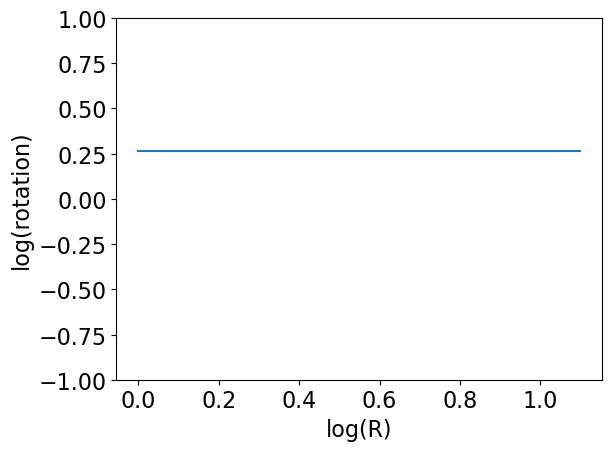

In [14]:
plt.Figure(figsize=(10,10))
plt.subplots(tight_layout=True)
plt.plot(Rs,180*(np.pi - thetas3[:20])/np.pi)




plt.xlabel("R")
plt.ylabel("rotation")
plt.ylim([0,2])
# plt.title(f"rotation vs R")




plt.savefig("degree3.png", bbox_inches="tight")
plt.show()



plt.Figure(figsize=(10,10))
plt.subplots(tight_layout=True)
plt.plot(log(Rs),log(180*(np.pi - thetas3[:20])/np.pi))



slope  = scipy.stats.linregress(np.log(Rs),np.log(180*(np.pi - thetas3[:20])/np.pi))[0]

plt.xlabel("log(R)")
plt.ylabel("log(rotation)")
plt.ylim([-1,1])

# plt.title(f"log(rotation) vs log(R), slope = {np.round(slope,3)}")




plt.savefig("log_degree3.png", bbox_inches="tight")
plt.show()

In [15]:
R = 1

In [16]:
As = np.linspace(5,25,20)*R

In [17]:
data2 = np.zeros((20,6))
thetas2 = np.zeros(20)
for i in range(20):

    a = As[i]
    epsilon = 0.3*a
    closing  = a - np.arange(steps+1)*epsilon/steps
    opening = a - epsilon + np.arange(steps+1)*epsilon/steps
    opened = a *np.ones(steps+1)
    closed = (a-epsilon)*np.ones(steps+1)

    totalRotation = np.eye(3)
    totalDelta = 0


    
    rf1,delta,Rotation=  act(np.array([closing,opened,opened,opened]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf2,delta,Rotation=  act(np.array([closed,closing,opened,opened]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf3,delta,Rotation=  act(np.array([closed,closed,closing,opened]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf4,delta,Rotation=  act(np.array([closed,closed,closed,closing]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf5,delta,Rotation=  act(np.array([opening,closed,closed,closed]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf6,delta,Rotation=  act(np.array([opened,opening,closed,closed]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf7,delta,Rotation=  act(np.array([opened,opened,opening,closed]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)

    rf8,delta,Rotation=  act(np.array([opened,opened,opened,opening]),R)
    totalDelta += np.matmul(totalRotation,delta)
    totalRotation  = np.matmul(Rotation,totalRotation)
    
    
    data2[i,0:3] = totalDelta
    data2[i,3:6] = Rot.from_matrix(totalRotation).as_euler("xyz",degrees=True)
    thetas2[i] = np.arccos((1 - np.trace(totalRotation))/2)

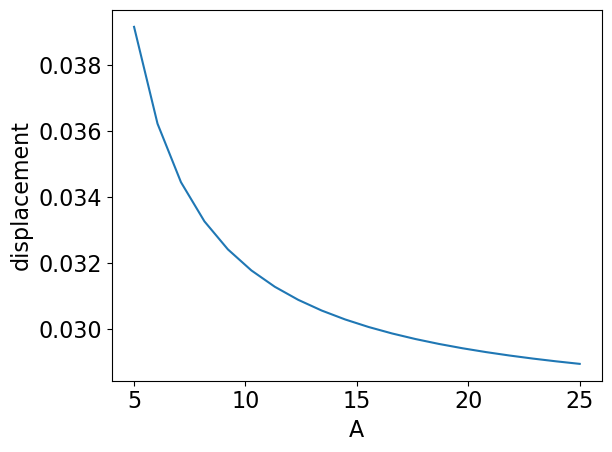

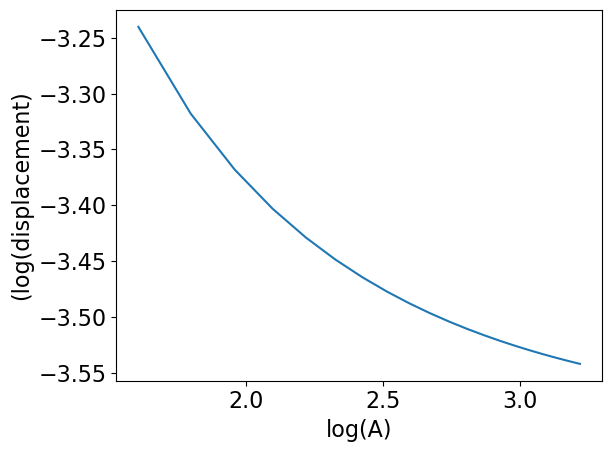

In [18]:


plt.Figure(figsize=(10,10))
plt.subplots(tight_layout=True)
plt.plot(As,np.linalg.norm(data2[:,0:3],axis=1))



# slope  = scipy.stats.linregress(np.log(epsilons),np.log(np.linalg.norm(data[:,0:3],axis=1)))[0]

plt.xlabel("A")
plt.ylabel("displacement")
# plt.title(f"displacement vs A")





plt.savefig("displacement2.png", bbox_inches="tight")
plt.show()



plt.Figure(figsize=(10,10))
plt.subplots(tight_layout=True)

plt.plot(np.log(As),np.log(np.linalg.norm(data2[:,0:3],axis=1)))



slope  = scipy.stats.linregress(np.log(As),np.log(np.linalg.norm(data2[:,0:3],axis=1)))[0]

plt.xlabel("log(A)")
plt.ylabel("(log(displacement)")
# plt.title(f"log(displacement) vs log(A), slope = {np.round(slope,3)}")





plt.savefig("log_displacement2.png", bbox_inches="tight")
plt.show()





# plt.Figure(figsize=(10,10))

# plt.plot(As,np.linalg.norm(data2[:,0:3],axis=1))

# plt.savefig("displacement2.png")

-0.16659725329922934
-0.16180152675140125
-0.16294937419612868
0.07081448339547222
0.071383717137344
0.07046730196010045


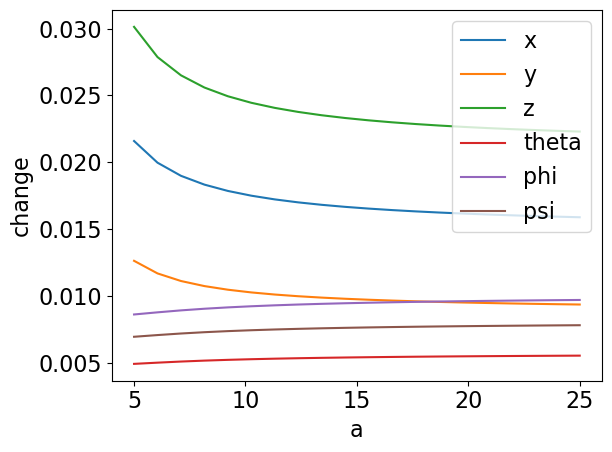

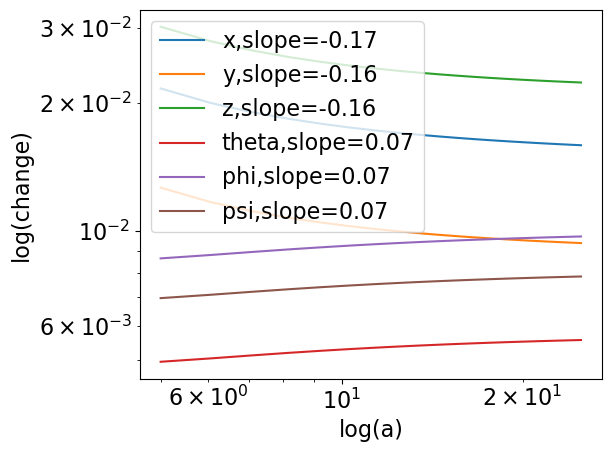

In [19]:
slopes2 = []  
for i in range(6):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(As[:]),np.log(np.abs(data2[:,i])))
    slopes2.append(slope)
    print(slope)

plt.Figure(figsize=(10,10))
plt.subplots(tight_layout=True)

# plt.title("change in position and orientation vs a for R=1 and eps=0.3")
plt.xlabel("a")
plt.ylabel("change")
for i in range(3):
    plt.plot(As,np.abs(data2[:,i]))


for i in range(3,6):
    plt.plot(As,np.abs(0.01*data2[:,i]))

plt.legend(["x","y","z","theta","phi","psi"])
plt.savefig("1-4.png", bbox_inches="tight")
plt.show()


plt.Figure(figsize=(10,10))
plt.subplots(tight_layout=True)

# plt.title("log of change in position and orientation vs log of a for R=1 and eps=0.3")
plt.xlabel("log(a)")
plt.ylabel("log(change)")
for i in range(3):
    plt.loglog(As,np.abs(data2[:,i]))

for i in range(3,6):
    plt.loglog(As,0.01*np.abs(data2[:,i]))

plt.legend([f"x,slope={np.round(slopes2[0],2)}",f"y,slope={np.round(slopes2[1],2)}",f"z,slope={np.round(slopes2[2],2)}",f"theta,slope={np.round(slopes2[3],2)}",f"phi,slope={np.round(slopes2[4],2)}",f"psi,slope={np.round(slopes2[5],2)}"])
plt.savefig("1-5.png", bbox_inches="tight")
plt.show()


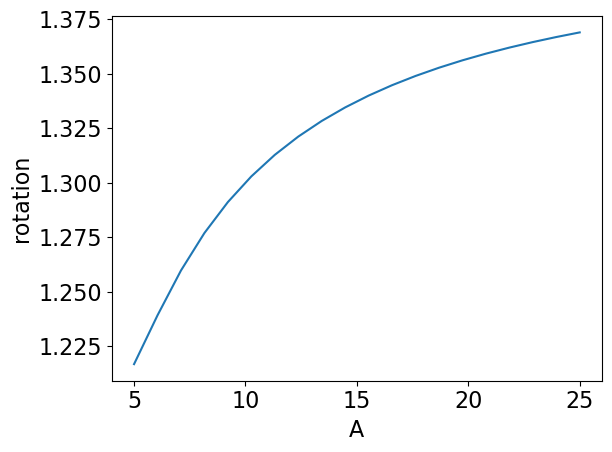

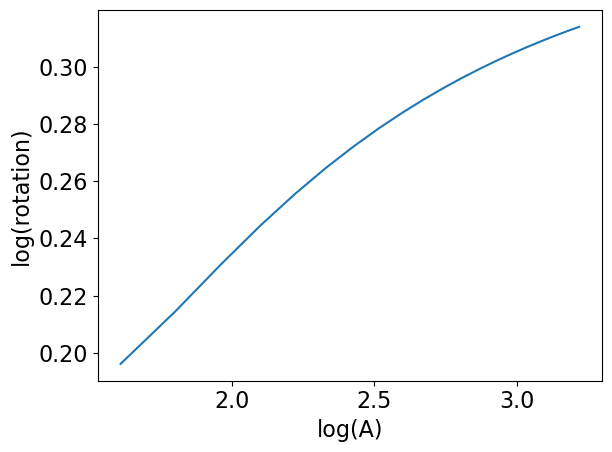

In [20]:
plt.Figure(figsize=(10,10))
plt.subplots(tight_layout=True)
plt.plot(As,180*(np.pi - thetas2[:20])/np.pi)




plt.xlabel("A")
plt.ylabel("rotation")
# plt.title(f"rotation vs A")




plt.savefig("degree2.png", bbox_inches="tight")
plt.show()



plt.Figure(figsize=(10,10))
plt.subplots(tight_layout=True)

plt.plot(log(As),log(180*(np.pi - thetas2[:20])/np.pi))



slope  = scipy.stats.linregress(np.log(As),np.log(180*(np.pi - thetas2[:20])/np.pi))[0]

plt.xlabel("log(A)")
plt.ylabel("log(rotation)")
# plt.title(f"log(rotation) vs log(A), slope = {np.round(slope,3)}")




plt.savefig("log_degree2.png", bbox_inches="tight")
plt.show()

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

In [25]:
epsilons ,
Rs,
As,

data1,
thetas1,
data2,
thetas2,
data3,
thetas3

NameError: name 'data1' is not defined